In [3]:
#\title{Compressão de Imagens em JPEG e Grayscale Através da
#Segmentação e da Transformada Discreta do Cosseno de Fourier
#Usando a Média Como Método Estatistico para a Filtragem de Coeficientes} 
#\author{Arthur Abrahão Santos Barbosa\\
#        Filipe Samuel da Silva}
#\maketitle 

# Compressão de Imagens

O termo Compressão se refere ao processo de reduzir a quantidade de dados requerida para representar uma dada quantidade de informação <cite data-cite = "a1"> </cite>. Uma das características mais comuns de uma imagem é que os pixels vizinhos tem similaridadedes e portanto contém informação redundante<cite data-cite = "a1"> </cite>. 

Através de diversas técnicas podemos encontrar e remover informações desnecessárias de uma imagem, diminundo o espaço ocupado em disco ocupado por esta mas mantendo uma qualidade bem próxima da original, com diferenças na maioria das vezes impercepitiveis. A transformada discreta de Fourier e a segmentação  podem ser usadas como ferramentas para se atingir este objetivo.


Há basicamente dois tipos de técnicas de compressão de imagens: Com Perda e Sem Perda. As técnicas sem perda são usadas quando se quer temporariamente reduzir a informação, Enquanto as técnicas com perda são usadas quando se quer permanente reduzir o tamanho de uma imagem. <cite data-cite = "s8"> </cite>

## O Formato JPEG

O termo JPEG é um acrônimo para Joint Photographic Experts Group, um comitê que tem uma longa tradição na criação de padrões de codificação de imagens sem movimento <cite data-cite = "s7"> </cite> .

JPEG  é um formato padrão de compressão  para imagens digitais,  O padrão JPEG apresenta quatro modos de compressão sendo um deles o JPEG com perdas (Lossy JPEG) também conhecido como JPEG-DCT pois utiliza como ferramenta a Transformada do Cosseno Discreta  (Discrete Cosine Transform) para comprimir a imagem <cite data-cite = "s3"> </cite><cite data-cite = "s6"> </cite><cite data-cite = "s2"> </cite>. 

## A Transformada do Cosseno Discreta de Fourier (DCT)

A DCT é uma das transformadas discretas de Fourier, ela transforma um sinal do domínio do espaço para o domínio da frequência. Ela ajuda a separar  a imagem em partes (faixas expectrais)  de diferente importâncias em relação a qualidade da imagem<cite data-cite = "s9"> </cite><cite data-cite = "s10"> </cite>. A fórmula da DCT é dada por:

$$ X[k] =  \alpha[k]\sum\limits_{n=0}^{N-1}x[n]cos\left(\frac{k\pi(2n + 1)}{2N}\right) $$

e a fórmula da DCT inversa é dada por:

$$ x[n] =  \sum\limits_{k=0}^{N-1}\alpha[k]X[k]cos\left(\frac{k\pi(2n + 1)}{2N}\right) $$

onde:

$$ \alpha[k] = \frac{1}{\sqrt{N}} \; se \; k = 0 $$
$$\alpha[k] = \sqrt{\frac{2}{N}} \;caso\;contrario$$

Como a imagem é um objeto bidimensional é necessário usar a transformada em duas dimensões do cosseno que é dada por:

$$ F(u,v) =  C(u)C(v)\sum\limits_{m=0}^{N-1}\sum\limits_{n=0}^{N-1}f(m,n) cos\left(\frac{u\pi(2m+1)}{2N}\right) cos\left(\frac{v\pi(2n+1)}{2N}\right)$$

E sua transformada inversa por:

$$ F(m,n) = \sum\limits_{u=0}^{N-1}\sum\limits_{v=0}^{N-1} C(u)C(v)F(u,v) cos\left(\frac{u\pi(2m+1)}{2N}\right) cos\left(\frac{v\pi(2n+1)}{2N}\right)$$

onde:
$$ C(\gamma) = \frac{1}{\sqrt{N}} \; se \; k = 0 $$
$$ C(\gamma) = \sqrt{\frac{2}{N}} \;caso\;contrario$$


<cite data-cite = "a4"> </cite><cite data-cite = "a5"> </cite>

## Usando DCT na Compressão de Imagens JPEG em Grayscale

No projeto a compressão de imagens foi definida de acordo com os seguintes passos:

* Passo 1: Aplica-se  o DCT bidimensional em segmentos 8 por 8 da imagem
* Passo 2: Descobre-se o valor da média da magnitude coeficientes de cada segmento 8 por 8 e se iguala a zero todos os coeficientes que tiverem o módulo menor que a média (este método se chama thresholding).
* Passo 3: Aplica-se o DCT inverso bidimensional em cada segmento 8 por 8 da imagem no domínio da frequência para retorná-la ao domínio do espaço

O DCT apresenta um melhor desempenho que a transformada Discreta de Fourier pois fornece um maior acúmulo dos coeficientes mais significativos da imagem, proporcionando uma melhor capacidade de compressão <cite data-cite = "s11"> </cite>, porém como é um método de compressão com perda ele não permite a recuperação da imagem original (sem nenhum coeficiente igualado a zero).

O projeto trabalha com imagens em Grayscale em vez de RGB ou BGR porque imagens coloridas precisam de três dimensões para ser representadas, pois cada pixel da imagem é representado por três valores, que representam as intensidades das cores vermelha (Red), verde (Green) e azul (Blue). Enquanto as imagens em Grayscale apresentam apenas duas dimensões, pois é necessário apenas a intensidade de cinza para representar cada pixel. É possível trabalhar com a compressão de imagens coloridas com a transformada de fourier, mas o método teria que sofrer uma forte adaptação.

# Setup Inicial

## Bibliotecas Usadas no Projeto

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#Funções que implementam a transformada discreta do cosseno de fourier
from scipy.fftpack import dct, idct
import cv2 # Biblioteca usada para importar imagens
from math import floor,log10
from IPython.display import Latex
from os import stat,listdir
from os.path import isfile, join


## Funções Auxiliares

O módulo scipy.fftpack fornece funções apenas para transformadas de uma dimensão, a função abaixo converte uma função de transformada discreta de fourier unidimensional para bidimensional.

In [2]:
def transform2D(img,function):
    return np.transpose(function(np.transpose(function(img,norm = "ortho")),norm = "ortho"))

Função responsável por segmentar uma imagem e aplicar uma função sobre os segmentos de tamanho **size X size** da imagem.

In [3]:
def segmentation(img,size,function=transform2D,function2 =dct):
    copy = np.zeros(img.shape)
 
    for i in range(copy.shape[0]//size):
        for j in range(copy.shape[1]//size):
            copy[i*size:(i+1)*size,j*size:(j+1)*size] = function(img[i*size:(i+1)*size,j*size:(j+1)*size],function2)
        
    return copy

A função abaixo é uma função auxiliar que é utilizada para o melhor entendimento da função **thresholdingPC**. Ela retorna o index que representa **n%** da matriz que representa a imagem quando esta é convertida para um array unidimensional.

In [4]:
def percent(img,n):
    return floor((img.shape[0]*img.shape[1])*(n/100))

Função responsável por filtrar através do método thresholding de segmentação, a imagem no domínio da frequência. Esta função iguala a zero os valores de frequência que estão abaixo de um certo limiar, que é cálculado através do enésimo valor de maior magnitude da matriz que representa a imagem.

In [5]:
def thresholdingPC(img,pc):
    imgCopy = img.copy()
    sortedCts = np.sort(abs(imgCopy.ravel()))
    threshold = sortedCts[-percent(imgCopy,pc)]
    imgCopy[abs(imgCopy) < threshold] = 0;
    return imgCopy

Função auxiliar para a função **thresholdingMean**. Ela recebe um segmento de uma imagem  **img** que já passou pela tranformada de fourier, e baseado no critério dado pela função **function** calcula o limiar (threshold) para filtrar os coeficientes redundantes e igualá-los a zero.

In [6]:
def filterImg(img,function):
    imgCopy = img.copy();
    threshold = function(np.abs(imgCopy))
    #print(threshold)
    imgCopy[abs(imgCopy) < threshold ] = 0
    return imgCopy

Função que filtra os segmentos da imagem, aplicando a média dos valores da matriz  de tamanho  **size X size**  como método estatistico para cálcular o limiar (threshold)

In [7]:
def thresholdingMean(img,size):
    imgCopy = img.copy()
    imgCopy = segmentation(imgCopy,size,filterImg,np.mean)
    return imgCopy;
    

Função que é um compilado das funções acima. Ela basicamente recebe uma imagem JPEG e algumas informações adicionais e executa a compressão desta. O passo a passo de como ela funciona será explicado com mais detalhes futuramente.

In [8]:
def compress(img, thresholding = thresholdingMean,argThres = 8, seg = 8, save = False, path = "imgCMP.jpg"):
    compImg = img.copy()
    compImg = segmentation(compImg,seg)
    compImg = thresholding(compImg,argThres)
    compImg = segmentation(compImg,seg,function2 = idct)
    if(save):
        cv2.imwrite(path,compImg)
    return compImg

Função que retorna a razão de compressão (Compressio Ratio)  de uma imagem

In [23]:
def CR(pathOrig, pathCmp):
    result = stat(pathOrig).st_size/stat(pathCmp).st_size
    return result

Função que cálcula a Raiz do Erro Quadrático Médio (Root Mean Square Error).

In [10]:
def RMSE(original, compressed):
    result = 0
    M = original.shape[0]
    N = original.shape[1]
    
    for i in range(M):
        for j in range(N):
            result += (compressed[i][j] - original[i][j])**2
    #print(result)
    return (result/(M*N))**(1/2)
        
    
    

Função que Cálcula a Relação Sinal-Ruído de Pico (Peak Signal Noise Ratio).

In [11]:
def PSNR(original,compressed):
    result = 20*log10(255/RMSE(original,compressed))
    return result

# Compressão de Imagens Na Prática

Primeiro é necessário importar imagem e salvar em uma variável em python.

In [24]:
path = "../BANCO-DE-IMAGENS/img6.jpg"
imgBGR = cv2.imread(path)

True

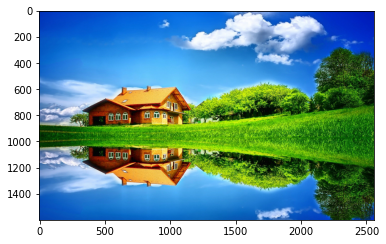

In [25]:
#Imagem é convertida de BGR para RGB para poder  ser mostrada
imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)
plt.imshow(imgRGB)
cv2.imwrite("generated-files/imgBGR.jpg",imgBGR)

Converte-se a imagem para Grayscale Para que o método de compressão funcione.

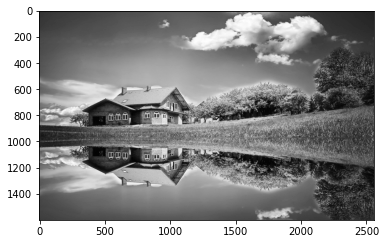

In [26]:
imgGRAY = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2GRAY)
plt.imshow(imgGRAY,cmap = "gray")


A imagem é salva para comparações futuras.

In [27]:
cv2.imwrite("generated-files/imgGRAY.jpg",imgGRAY)

True

Aplica-se a **Transformada Discreta do Cosseno de Fourier** em segmentos 8 por 8 da imagem. (Tamanho do segmento escolhido com base no padrão JPEG)

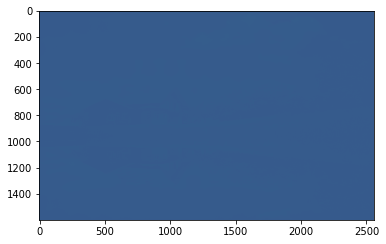

In [28]:
imgCMP = segmentation(imgGRAY,8,transform2D,dct)
plt.imshow(imgCMP)

Aplica-se um filtro na imagem para eliminar os coeficientes de menor relevância, usando a **média** como método estatístico para cálcular o limiar.

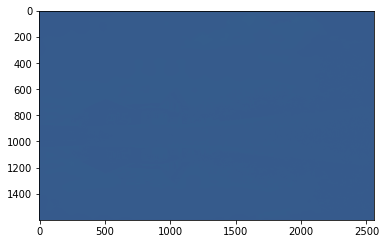

In [29]:
imgCMP = thresholdingMean(imgCMP,8)
plt.imshow(imgCMP)

Aplica-se a **Tranformada Discreta do Coseno de Fourier Inversa** sobre segmentos de tamanho 8 por 8 da imagem para se recuperar a imagem original

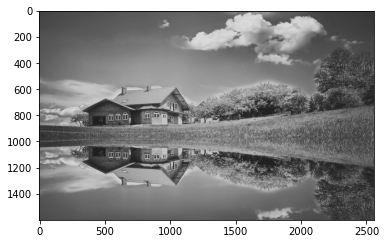

In [30]:
imgCMP = segmentation(imgCMP,8,function2 = idct)
plt.imshow(imgCMP, cmap = "gray")

Salva-se a imagem comprimida para comparações futuras.

In [31]:
cv2.imwrite('generated-files/imgCMP.jpg',imgCMP)

True

O Mesmo resultado poderia ser obtido através da função **compress** que unifica todos os passos acima

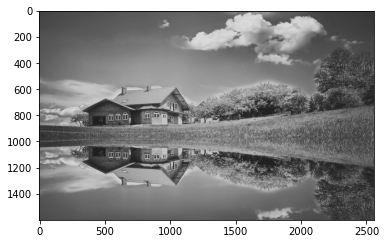

In [32]:
test = compress(imgGRAY,thresholding = thresholdingMean, argThres = 8,save = True)
plt.imshow(test, cmap = "gray")

## Comparações entre  a Imagem Comprimida e a Imagem Original

A imagem original (em Grayscale) ocupa 1.1 MB de espaço em disco (1,131,392 bytes). Enquanto a imagem comprimida ocupa 698.0 kB (697,977 bytes).

A razão de compressão de uma imagem pode ser obitida através da seguinte fórmula:

$$C = \frac{n_o}{n_c}$$

onde:

* C = Taxa de Compressão da imagem
* $n_c$ = número de bytes (ou bits) da imagem comprimida
* $n_o$ = número de bytes (ou bits) da imagem original

<cite data-cite = "a1"> </cite>

Para o caso acima a taxa de compressão será dada por:

$$C = \frac{1,131,392 bytes}{697,977 bytes} = 1.620958857$$

A razão de compressão da imagem foi de aproximadamente de 1.6 : 1, o que é um valor significativo para apenas uma imagem, mas caso precissassemos armazenar milhares de imagens  essa diferença se acumularia fazendo a quantidade de espaço salvo ser muito maior. 


A diferença de qualidade entres as duas imagens é quase imperceptível a olho nu, porém para melhor análise será cálculado o PSNR das duas imagens. 

PSNR (Peak Signal to Noise Ratio) se refere a razão entre a potência máxima de um sinal e a potência do ruído que afeta fidelidade da representação de um sinal. Ele é um dos métodos mais comumente usado como medida de qualidade da imagem resconstruída <cite data-cite = "a1"> </cite>. Quanto maior for o PSNR melhor a imagem foi reconstruida.<cite data-cite = "s12"> </cite>

A fórmula de Peak Signal to Noise Ratio é dada por:

$$PSNR = 20log_{10} \left(\frac{MAX_f}{RMSE}\right)$$

onde:

* $MAX_f$: O valor máximo que o sinal pode atingir na imagem original, que no nosso caso será igual a 255.

* $RMSE =  \sqrt{\frac{1}{M*N}\sum\limits_{i=0}^{M-1}\sum\limits_{j=0}^{N-1}(g(i,j) - f(i,j))^2}$

sendo que:

* $M$ e $N$ são as dimensões da imagem
* $g(i,j)$ é a imagem original
* $f(i,j)$ é a imagem reconstruida

<cite data-cite = "s12"> </cite>

O PSNR das imagens é dado por:

In [174]:
print(PSNR(imgGRAY, imgCMP), "db")

33.36912844685023 db


Os valores típicos para imagens comprimidas com perda estão geralmente entre 30 e 50db. logo 33.36 db de PSNR é um valor considerado típico.

# Experimentos

## Análise do Desempenho do Algoritmo de Compressão para Imagens Grandes

Como a imagem usada no exemplo anterior é muito pequena (em relação ao espaço ocupado em disco), a taxa de compressão desta foi muito baixa, porém imagens maiores e de melhor qualidade tem a tendência de obter uma maior taxa de compressão, para provar isso será executado um teste que comparará as estatistica de compressão de imagens de tamanho significativamente maior do que a usada anteriormente.

O Banco de imagens que será usado será foi tirado do álbum  Black & White Mono  do fotógrafo Chris Combe <cite data-cite = "s13"> </cite>. Estas fotos estão sobre a licensa <a href = "https://creativecommons.org/licenses/by/2.0/legalcode">Creative Commons</a>. Será feito uma análise da taxa de Compressão e do PSNR destas imagens.

Primeiramente, cria-se uma lista com o nome de todas as imagens JPEG que estão no diretório.

In [33]:
path = "../BANCO-DE-IMAGENS/Chris-Combe/mono"
files = [f for f in listdir(path) if isfile(join(path,f))]

Salva-se todas as imagens em um array.

In [34]:
images = []
N = 5 # Número de imagens que serão processadas
# Quanto maior o valor de N maior o tempo de execução do programa
# Dependendo do Valor de N o Programa pode Crashar
# 5 imagens demoram em torno de 30 segundos a um minuto dependendo do computador
for file in files[0:N]:
    images.append(cv2.imread(join(path,file)))
    print(join(path,file))
print("Done")

../BANCO-DE-IMAGENS/Chris-Combe/mono/edinburgh-vista-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/kelpies-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/castle-stalker-le-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/some-thing.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/pier-seats.jpg
Done


Converte-se as imagens para Grayscale

In [35]:
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i],cv2.COLOR_BGR2GRAY)
    print(join(path,'grayscale',files[i]))
    cv2.imwrite(join(path,'grayscale',files[i]),images[i])
print("Done")    

../BANCO-DE-IMAGENS/Chris-Combe/mono/grayscale/edinburgh-vista-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/grayscale/kelpies-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/grayscale/castle-stalker-le-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/grayscale/some-thing.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/grayscale/pier-seats.jpg
Done


Aplica-se o algoritmo de compressão nas imagens

In [36]:
imagesCMP = []

for i in range(len(images)):
    imagesCMP.append(compress(images[i],save = True, path = join(path,'compressed',files[i])))
    print(join(path,'compressed',files[i]))
print("Done")

../BANCO-DE-IMAGENS/Chris-Combe/mono/compressed/edinburgh-vista-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/compressed/kelpies-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/compressed/castle-stalker-le-mono.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/compressed/some-thing.jpg
../BANCO-DE-IMAGENS/Chris-Combe/mono/compressed/pier-seats.jpg
Done


Compara-se os resultados de compressão de cada imagem.

In [37]:
#Cria uma string com um número n de espaços
def space(n):
    string =""
    for i in range(n):
        string += " "
    return string


crs =[]
rmses =[]
psnrs = []

#Imprime as estatisticas de compressão das imagens
print("----------------------------------------------------------------------")
print("IMAGEM                                 CR      RMSE     PSNR")
print()
for i in range(len(images)):
    
    imagens = files[i] + space(37-len(files[i]))
    cr = round(CR(join(path,'grayscale',files[i]),join(path,'compressed',files[i])),2)
    crS = str(cr) + space(8-len(str(cr)))
    rmse = round(RMSE(images[i],imagesCMP[i]),2)
    rmseS = str(rmse) + space(8-len(str(rmse)))
    psnr = round(PSNR(images[i],imagesCMP[i]),2)
    psnrS = str(psnr) + space(8-len(str(psnr)))
    print(imagens, crS, rmseS, psnrS)
    
    #Armazena os Valores obtidos para análise futura dos dados
    crs.append(cr)
    rmses.append(rmse)
    psnrs.append(psnr)
    
print("---------------------------------------------------------------------")
print("Done")

----------------------------------------------------------------------
IMAGEM                                 CR      RMSE     PSNR

edinburgh-vista-mono.jpg              2.14     6.68     31.63   
kelpies-mono.jpg                      1.68     8.82     29.22   
castle-stalker-le-mono.jpg            3.05     5.58     33.2    
some-thing.jpg                        3.26     2.26     41.04   
pier-seats.jpg                        1.93     9.19     28.86   
---------------------------------------------------------------------
Done


Analisa-se as Estatisticas obtidas

In [38]:
print("------------------------------")
print(space(10),"Média")
print("------------------------------")
print("CR       RMSE     PSNR")
print()
print(round(np.mean(crs),2),space(3),round(np.mean(rmses),2),space(3),round(np.mean(psnrs),2))
print("-------------------------------")


print("------------------------------")
print(space(10),"Mediana")
print("------------------------------")
print("CR       RMSE     PSNR")
print()
print(round(np.median(crs),2),space(3),round(np.median(rmses),2),space(3),round(np.median(psnrs),2))
print("-------------------------------")

print("------------------------------")
print(space(3),"Desvio Padrão Amostral")
print("------------------------------")
print("CR       RMSE     PSNR")
print()
print(round(np.std(crs,ddof=1),2),space(3),round(np.std(rmses,ddof=1),2),space(3),round(np.std(psnrs,ddof=1),2))
print("-------------------------------")



------------------------------
           Média
------------------------------
CR       RMSE     PSNR

2.41     6.51     32.79
-------------------------------
------------------------------
           Mediana
------------------------------
CR       RMSE     PSNR

2.14     6.68     31.63
-------------------------------
------------------------------
    Desvio Padrão Amostral
------------------------------
CR       RMSE     PSNR

0.7     2.81     4.94
-------------------------------


As medidas de tendência central apresentaram uma taxa de compressão bem próxima de 2:1, e PSNR em torno de 32, mostrando que as imagens grandes sofreram uma diminuição significante em seu tamanho e mantiveram uma qualidade considerável, porém as medidas de desvio padrão deram valores consideravelmente altos. A partir disto conclui-se que dependendo das propriedades da imagem (quantidade de coeficientes redundantes após a aplicação da transformada) pode-se obter uma razão de compressão baixa e que imagens maiores com melhor qualidade tendem a obter um melhor CR (Compression Rate). 

## Limite de Compressão de uma Imagem

Anteriormente Foi usado o método estatistico da média como limiar para filtrar as frequências com menor importância na qualidade visual da imagem, o que foi um método relativamente "seguro" pois foi possível obter uma taxa de compressão considerável mantendo a qualidade da imagem bem próxima da original.

Porém é Possível ir mais além e reduzir a imagem até um por cento dos coeficientes da transformada de Fourier. Mas a partir de quantos por cento de redução a imagem continua com uma qualidade aceitável? Para responder a seguinte pergunta executaremos alguns testes.

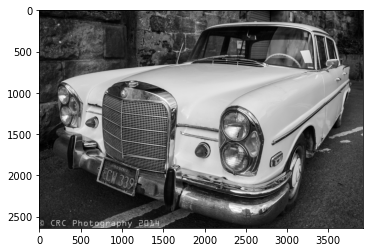

In [15]:
img = cv2.imread(join(path,"the-old-merc.jpg"))
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap = "gray")

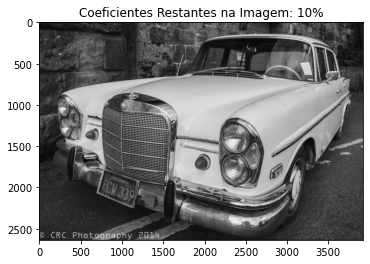

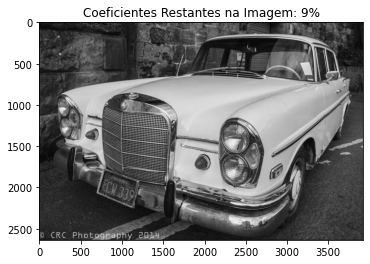

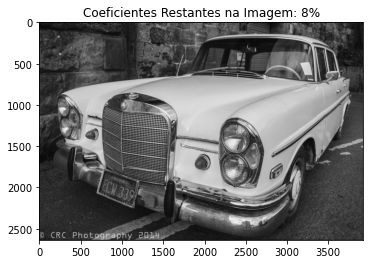

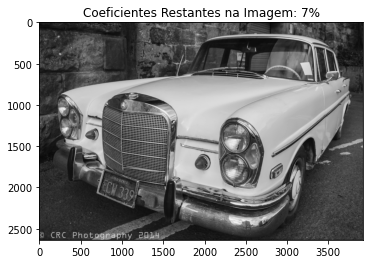

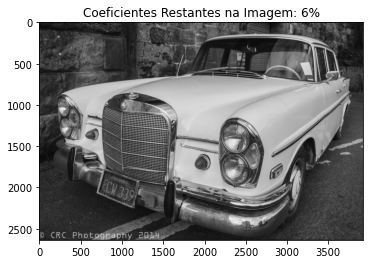

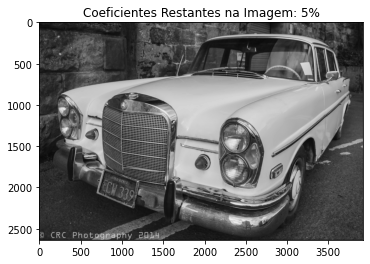

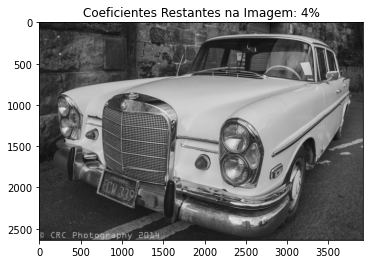

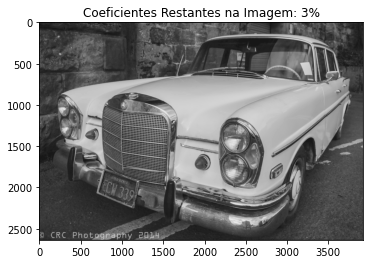

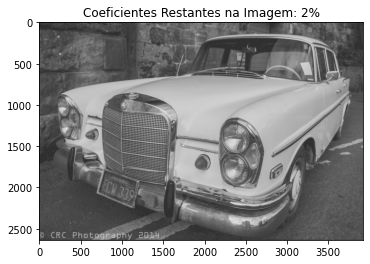

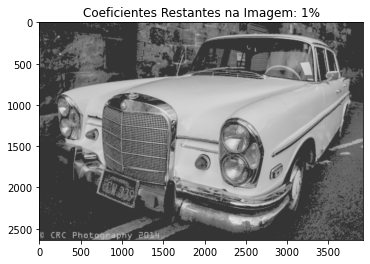

In [19]:
imgsCMP = []
for i in range(10,0,-1):
    imgCMP = compress(img,thresholdingPC,i)
    imgsCMP.append(imgCMP)
    #print("Compressão: ",i,"%")
    cv2.imwrite("imgCMP" + str(i) +".jpg",imgCMP)
    plt.figure()
    plt.title("Coeficientes Restantes na Imagem: " + str(i) + "%" )
    plt.imshow(imgCMP,cmap = "gray")

In [39]:
CR(join(path,"the-old-merc.jpg"),"imgCMP2.jpg")

14.260479980391649

Surpreendentemente a Imagem que tinha originalmente 6.1 MB manteve uma qualidade considerável mantendo apenas 2% dos coeficientes após a aplicação da transformada, tendo seu tamanho comprimido para 424.3 kB, tendo uma razão de compressão de  14:1, A imagem só começou a distorcer quanto apenas 1% dos coeficientes foram mantidos. 

Verificando o valor de PSNR da imagem temos:

In [21]:
PSNR(img,imgsCMP[-2])

28.486302618425377

O valor de 28.48 db é abaixo do ideal mas se escolhermos a imagem com 3% dos coeficientes temos:

In [22]:
PSNR(img,imgsCMP[-3])

30.83279674184417

Que é um valor aceitável para o método de compressão usado neste projeto. Neste caso o tamanho da imagem  é 659.9 kB e sua razão de compressão é dada por:

In [41]:
CR(join(path,"the-old-merc.jpg"),"imgCMP3.jpg")

9.210868820641625

Que ainda é uma razão de compressão extremamente alta.

# Bibliografia




M. Kanaka Reddy , V. V. Haragopal and S. A. Jyothi Rani "Statistical Image Compression using Fast Fourier Coefficients" , Dec. 2016


J.Feydy "Part 6: Fourier analysis and JPEG compression", Feb.2019. [Online]. Available: \url{http://www.jeanfeydy.com/Teaching/MasterClass_Radiologie/Part%206%20-%20JPEG%20compression.html}


S. W. Smith, "The Scientist and Engineer's Guide to
Digital Signal Processing",[Online]. Available: \url{http://www.dspguide.com/ch27/6.htm}



J. F. Neto, "Compressão Sem Perdas de Imagens Digitais", [Online]. Available: \url{http://www.dpi.inpe.br/~carlos/Academicos/Cursos/Pdi/SemPerdas.htm}


O. Hampiholi, "Image Compression — DCT Method", Mar.21. [Online]. Available: \url{https://towardsdatascience.com/image-compression-dct-method-f2bb79419587}


Johnsy,A. "2-D Discrete Cosine Transform", [Online]. Available: \url{https://www.imageeprocessing.com/2013/03/2-d-discrete-cosine-transform.html}


S.Thayammal and D.Selvathi "A Review On Segmentation Based Image Compression Techniques",2013

L. Wake, "What is a JPEG file?", Apr.2019, [Online].
Available: \url{https://digitalcommunications.wp.st-andrews.ac.uk/2019/04/08/what-is-a-jpeg-file/}


Joint Photographic Experts Group, "ABOUT JPEG",[Online]. Available: \url{https://jpeg.org/about.html}


Krita Manual, "Lossy and Lossless Image Compression",
[Online]. Available: \url{https://docs.krita.org/en/general_concepts/file_format/lossy_lossless.html}


E. Roberts, "The Discrete Cosine Transform (DCT)", [Online]. Available: \url{https://cs.stanford.edu/people/eroberts/courses/soco/projects/data-compression/lossy/jpeg/dct.htm}


D. Marshal, "The Discrete Cosine Transform (DCT)", Apr.2001. [Online]. Available: \url{https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/node231.html}


S. Cárceres, "Processamento de Imagem". [Online]. Available: \url{http://sheilacaceres.com/courses/pi/aula9/PI-9-Compressao.pdf}



A. Conci, "Transformada de Discreta de Cosenos DCT"


W. R. Schwartz and H. Pedrini, "Aspectos Teóricos das Transformadas de Imagens"


National Instruments, "Peak Signal-to-Noise Ratio as an Image Quality Metric". Dec.2020. [Online]. Available: \url{https://www.ni.com/pt-br/innovations/white-papers/11/peak-signal-to-noise-ratio-as-an-image-quality-metric.html}


C. Combe, "Black \& White Mono". [Online]. \url{https://www.flickr.com/photos/cosmicherb70/albums/72157631496545108}